<a href="https://colab.research.google.com/github/ondraperny/BI-BAP-2020/blob/master/DenseNet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DenseNet based model
---
### Code parts(description of colab cells):
**Imports** - contain all used imports with descriptions \
**Colab essentials** - when running code on Colab, mount Google Drive so data can be read from there. \
**Constants declaration** - declaring input parameters \
**Data augmentation** - defining functions for importing and augmenting data in Keras \
**Auxiliary functions** - any functions non-related to ML training, usually for graphical output \
**Model definition** - Defining keras models \
**Training model** - initialization and training model






## Imports


In [ ]:
# For graphical outpus, images preview and training results plot representation
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.keras import backend
# Generator used for loading data into Keras model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Essentials for creating model architecture, model class, layers and optimizers
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import he_uniform 
# Logger for logging results from training model
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

# System functions and path processing
import sys
import os

# Support functions for saving and loading model
from tensorflow.keras.models import load_model

## Colab essentials
Running code on Colab and local requires slightly different, prerequisites (as different paths, etc.)
For differentiating where code is run, variable IN_COLAB is used, if True then run is in Colab (so rest of code can reflect that)

In [ ]:
# check if code run on colab or local, if in Colab then True
IN_COLAB = 'google.colab' in sys.modules

# if run in Colab, then mount to run Google Drive file system
if IN_COLAB:
  # Mount google drive
  from google.colab import drive
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##  Constants declaration


##### Constants that are expected to be directly changed (input parameters)

In [ ]:
# path to the directory with input
PATH="/content/drive/My Drive/SKOLA/Bachelor_work/XR_SHOULDER/"

# constants declaration
IMG_SIZE=(224,224)
INPUT_SHAPE = (*IMG_SIZE, 3)
BATCH_SIZE = 32

NUMBER_CLASSES = 2
NUMBER_EPOCHS = 50

##### Deriving other constants from given values

In [ ]:
def files_number(PATH):
  """find number of files(recursively) in given directory(path)"""
  total = 0
  for root, dirs, files in os.walk(PATH):
      total += len(files)
  return total

# if run on local machine, change path to correspond my local system paths
if not IN_COLAB:
  PATH = "G:"+PATH[14:].replace('/', '\\\\')

PATH_TRAIN = PATH + 'train'
PATH_VALID = PATH + 'valid'
# calculate number of steps per epoch and validation steps from input values
# and constants
train_img_num = files_number(PATH_TRAIN)
valid_img_num = files_number(PATH_VALID)

NUMBER_STEPS_PER_EPOCH = train_img_num // BATCH_SIZE
NUMBER_VALIDATION_STEPS = valid_img_num // BATCH_SIZE

print("Number of steps per epoch:", NUMBER_STEPS_PER_EPOCH)
print("Number of validation steps:", NUMBER_VALIDATION_STEPS)

Number of steps per epoch: 130
Number of validation steps: 17


## Data augmentation
Currently image augmentation will be done by parameters of ImageDataGenerator.
If in future this solution will be insufficient, I will change it.

In [ ]:
def ImageDataGenerator_def():
  datagen = ImageDataGenerator(
    # set rescaling factor (applied before any other transformation)
    rescale=1. / 255,
    # randomly change brightness of picture 
    brightness_range=[0.9,1.1],
    # randomly rotate images in the range (degrees, 0 to 180)
    rotation_range=30,
    # randomly flip images over horizontal axis
    horizontal_flip=True,
  )
  return datagen

def load_from_directory(dir_path, data_generator):
  '''Load images from directory while transforming data (based on parameters),
  contain other parameters for data augmentation'''
  batches = data_generator.flow_from_directory(
    # path to target directory from which data will be loaded
    dir_path,
    # resize all input images to IMG_SIZE
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle = True,
  )
  return batches

In [ ]:
data_generator = ImageDataGenerator_def()

train_batches = load_from_directory(PATH_TRAIN, data_generator)
valid_batches = load_from_directory(PATH_VALID, ImageDataGenerator(rescale=1. / 255))

print("Found indices: ", end='')
print(train_batches.class_indices)

Found 8379 images belonging to 2 classes.
Found 563 images belonging to 2 classes.
Found indices: {'train_negative': 0, 'train_positive': 1}


## Auxiliary functions

In [ ]:
def label_to_string(label):
  '''Map label value to descriptive string'''
  if(label == 0):
    return "Negative"
  else:
    return "Positive"


def show_sample_images(batches):
  '''Show one batch of training images (max 25 images)'''
  image_batch, label_batch = batches.next()
  plt.figure(figsize=(10,10))
  for n in range(min(len(image_batch), 25)):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n][:,:,0], cmap=cm.gray)
    plt.title(label_to_string(label_batch[n]))
    plt.axis('off')
  plt.show()


def load_keras_model(PATH_TO_MODEL):
  '''Return loaded model saved model, based on value of PATH'''
  return load_model(PATH_TO_MODEL)


def plot_model_graph(model):
  '''Print to output and save to file the graph of model layers
  and its parameters, based on value of PATH'''
  plot_model(model, to_file=PATH+"model_arch.png", show_shapes=True)


def plot_training(history):
  '''Plot diagnostic learning curves, print them to output and save them
  to file'''
  # plot loss
  plt.figure(figsize=(10,10))
  plt.subplot(211)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.ylim(bottom=0.4, top=0.8)
  plt.xlim(left=0, right = NUMBER_EPOCHS - 1)
  
  # plot accuracy
  plt.subplot(212)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.ylim(bottom=0.5, top=1)
  plt.xlim(left=0, right = NUMBER_EPOCHS - 1)
  plt.tight_layout(pad=1.0)

  # save plot to file
  plt.savefig(PATH + 'acc_loss_plot_densenet.png')
  plt.show()
  plt.close()


def cohen_kappa_metric(model_output, expected_output):
  '''calculate cohen kappa metric between model's output and expected output 
  (golden standard defined in MURA dataset paper) 
  
  Parameters
  ----------
  model_output : List
    a list of zeroes and ones as predicted results from model (zero for negative)
  expected_output : List
    a list of zeroes and ones as reported results for testing data

  Returns
  -------
  Float
    Cohen kappa metric score value
  '''
  from sklearn.metrics import cohen_kappa_score

  if len(model_output) != len(expected_output):
    print("Input strings for Kappa metrics don't have the same size.\
    Can't be compared")
    return 0.0
  else:
    return cohen_kappa_score(model_output, expected_output)


def percentage(all_imgs, correct_imgs):
  '''Calculate percentage of correct images'''
  return 100 * float(correct_imgs)/float(all_imgs)


def predict(model):
  '''Use model to predict whether imgs are positive or negative

  Parameters
  ----------
  model : tensorflow.python.keras.engine.sequential.Sequential
    model used for prediction

  Returns
  -------
  List
    A list list of zeroes and ones as ground_truth values (one for positive and
    zero for negative result)
  List
    A list list of zeroes and ones as prediction values (one for positive and
    zero for negative result)
  '''
  ground_truth = []
  predictions = []

  test_batches = ImageDataGenerator(rescale=1. / 255).flow_from_directory(
    # path to target directory from which data will be loaded
    PATH_VALID,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary',
    shuffle = False,
  )

  for i in range(len(test_batches.filenames)):
    image, label = test_batches.next()

    prediction = model.predict(image)
    if prediction > 0.5:
      predictions.append(1)
    else:
      predictions.append(0)

    ground_truth.append(label.flat[0])
  
  return ground_truth, predictions


def get_acc_kappa(PATH_TO_MODEL):
  '''Call required functions to calculate kappa and accuracy

  Returns
  -------
  Float
    accuracy value
  Float
    kappa value
  '''
  model = load_keras_model(PATH_TO_MODEL)
  ground_truth, predictions = predict(model)

  new_gt = []
  for i in ground_truth:
    new_gt.append(int(i))

  correct_cnt = 0
  for i in range(len(new_gt)):
    if predictions[i] == new_gt[i]:
      correct_cnt += 1

  kappa = cohen_kappa_metric(new_gt, predictions)
  accuracy = percentage(len(new_gt), correct_cnt)

  print("Test images:", len(new_gt))
  print("Correctly predicted:", correct_cnt)
  print("Accuracy:", accuracy)
  print("Kappa   :", kappa)

  return accuracy, kappa

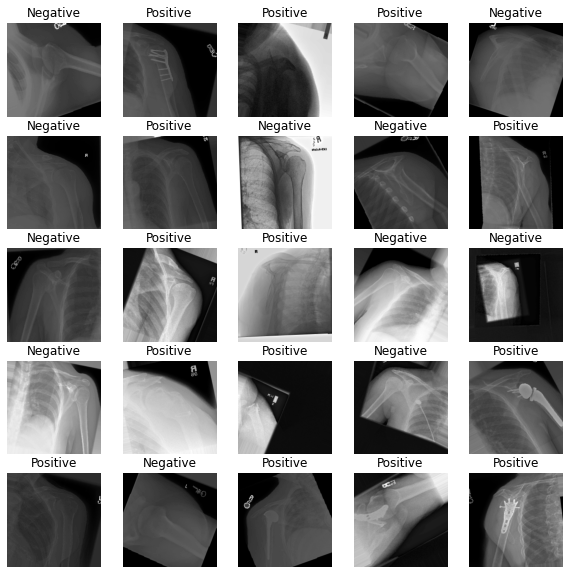

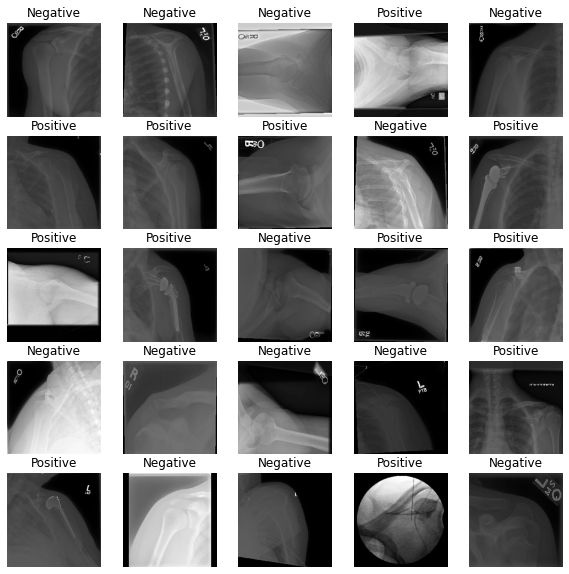

In [ ]:
show_sample_images(train_batches)
show_sample_images(valid_batches)

## Model definition

In [ ]:
def dense_based():
  # Pretrained DenseNet121 model, with imagenet weights
  imp_model = DenseNet121(input_shape=(None, None,3),
                          weights='imagenet',
                          include_top=False,
                          pooling='avg')
  
  # adding layers
  x = imp_model.output
  x = Flatten()(x)
  x = Dropout(0.1)(x)
  x = Dense(512,activation='relu') (x)
  x = Dropout(0.1)(x)
  x = Dense(256,activation='relu') (x)
  model_output = Dense(1,activation='sigmoid')(x)
  out_model = Model(inputs=imp_model.input, outputs=model_output)

  out_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['acc'])
  return out_model

## Training model

In [ ]:
# initialize model
model = dense_based()

# print summary info about model and its layers
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# saves the best model
model_checkpoint = ModelCheckpoint(filepath=PATH+"best_model.h5", monitor='val_acc', mode='max', save_best_only=True, verbose=1)

# training model
history = model.fit(train_batches,
                    epochs = NUMBER_EPOCHS,
                    workers = 0,
                    use_multiprocessing = False,  
                    steps_per_epoch = NUMBER_STEPS_PER_EPOCH,
                    validation_data = valid_batches,
                    validation_steps = NUMBER_VALIDATION_STEPS,
                    callbacks = model_checkpoint,
)

In [ ]:
# show plot of accuracy and loss (both training and validation) during training
plot_training(history) 

In [ ]:
# calculate and display kappa and accuracy of the model
get_acc_kappa(PATH+"best_model.h5")